# CS 512 Project
## Gated-GAN: Adversarial Gated Networks for Multi-Collection Style Transfer


### Imports and Installs

Tensorflow-addons needed to load datasets

In [ ]:
#!pip install tensorflow-addons==0.8.3
!pip install tensorflow-addons==0.9.1
!pip install tensorflow==2.2.0-rc3

     |████████████████████████████████| 1.0 MB 8.8 MB/s 
     |████████████████████████████████| 516.2 MB 10 kB/s 
     |████████████████████████████████| 454 kB 60.5 MB/s 
     |████████████████████████████████| 3.0 MB 55.3 MB/s 
     |████████████████████████████████| 2.9 MB 41.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Foun

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE

from tensorflow import keras
keras.__version__
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

from random import random
from numpy.random import randint
from numpy import asarray

import sys

### Loading and Preprocessing the Data

Below we are able to call tensorflow add-ons to retrieve 4 different datasets that we will use in our style transfer. Each dataset consists of an artist's work and real photographs to be used as content. Basic preprocessing and data augmentation is done to help stabilize training and create a more robust model.

In [ ]:
#code influenced by https://keras.io/examples/generative/cyclegan/

# Load the vangogh-photo dataset using tensorflow-datasets.
dataset, _ = tfds.load("cycle_gan/vangogh2photo", with_info=True, as_supervised=True)
dataset2, _= tfds.load("cycle_gan/cezanne2photo", with_info=True, as_supervised=True)
dataset3, _= tfds.load("cycle_gan/monet2photo", with_info=True, as_supervised=True)
dataset4, _= tfds.load("cycle_gan/ukiyoe2photo", with_info=True, as_supervised=True)

train_painter1, train_photo = ([dataset["trainA"], 'vangogh'], [dataset2["trainA"], 'cezanne'], [dataset3["trainA"], 'monet'], [dataset4["trainA"], 'ukiyoe']), dataset["trainB"]
test_painter1, test_photo = ([dataset["testA"], 'vangogh'], [dataset2["testA"], 'cezanne'], [dataset3["testA"], 'monet'], [dataset4["testA"], 'ukiyoe']), dataset["testB"]

# Define the standard image size.
orig_img_size = (143, 143)
# Size of the random crops to be used during training.
input_img_size = (128, 128, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 128x128
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteG67R7I/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteG67R7I/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteG67R7I/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteG67R7I/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0. Subsequent calls will reuse this data.
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/cezanne2photo/2.0.0.incompleteA47021/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/cezanne2photo/2.0.0.incompleteA47021/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cyc

In [ ]:
# code influenced by https://keras.io/examples/generative/cyclegan/

# Apply the preprocessing operations to the training data
train_painter1[0][0] = (
    train_painter1[0][0].map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_painter1[1][0] = (
    train_painter1[1][0].map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_painter1[2][0] = (
    train_painter1[2][0].map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_painter1[3][0] = (
    train_painter1[3][0].map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_photo = (
    train_photo.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_painter1[0][0] = (
    test_painter1[0][0].map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_painter1[1][0] = (
    test_painter1[1][0].map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_painter1[2][0] = (
    test_painter1[2][0].map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_painter1[3][0] = (
    test_painter1[3][0].map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_photo = (
    test_photo.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

### Previewing Dataset

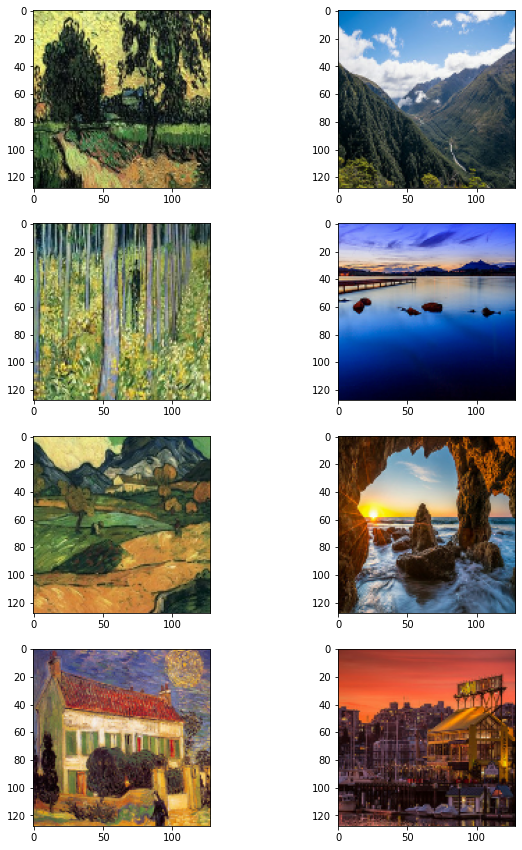

In [ ]:
#https://keras.io/examples/generative/cyclegan/

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_painter1[0][0].take(4), train_photo.take(4))):
    vangogh = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    photo = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(vangogh)
    ax[i, 1].imshow(photo)
plt.show()

### Defining Model Variables

In [ ]:
ng = 64
nd = 64
no_of_styles = 4

### Defining Model Blocks, Modules, and Networks

In [ ]:
#referenced from https://keras.io/examples/generative/cyclegan/

class ReflectionPadding2D(layers.Layer):
    
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

In [ ]:
# referenced https://github.com/colemiller94/gatedgan - PyTorch Code, not Keras

from tensorflow.keras.layers import ReLU, Input, BatchNormalization, Lambda, Conv2DTranspose
from tensorflow.keras.activations import tanh

class Generator(layers.Layer):
  def __init__(self, no_of_styles = 4, ng = 64):
    super(Generator, self).__init__()
    self.encoder = encoder(ng)
    self.transformer = transformer(no_of_styles, ng)
    self.decoder = decoder(ng)

  def __call__(self, content, label):
    e = self.encoder(content, label)
    t = self.transformer(e)
    d = self.decoder(t)
    return d


class encoder(layers.Layer):
  def __init__(self, ng):
    super(encoder, self).__init__()

    self.model = keras.Sequential(
    [
        ReflectionPadding2D(padding=(3,3)),
        layers.Conv2D(ng, kernel_size=(7, 7), kernel_initializer=kernel_init),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init), #instance normalization
        ReLU(),

        #effectively downsampling here
        layers.Conv2D(ng * 2, kernel_size=(3, 3), kernel_initializer=kernel_init, strides=2, padding ="same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init), #instance normalization
        ReLU(),

        layers.Conv2D(ng * 4, kernel_size=(3, 3), kernel_initializer=kernel_init, strides=2, padding ="same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init), #instance normalization
        ReLU()
    ])

  # we are returning a list with 
  #   - the first element as the model to be used as input to next module
  #   - the second element as the label to reference the style currently being trained
  def __call__(self, content, label):
    return [self.model(content), label]


class resnet_block(layers.Layer):
  def __init__(self, in_features):
    super(resnet_block, self).__init__()

    self.model = keras.Sequential(
    [
        ReflectionPadding2D(),
        layers.Conv2D(in_features, (3,3), (1,1), kernel_initializer=kernel_init, padding = "valid"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        ReLU(),
     
        ReflectionPadding2D(),
        layers.Conv2D(in_features, (3,3), (1,1), kernel_initializer=kernel_init, padding = "valid"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)                                 
    ])
  

  def __call__(self, x):
    return self.model(x)


class transformer(layers.Layer):
  def __init__(self, no_of_styles, ng):
    super(transformer, self).__init__()
    self.no_of_styles = no_of_styles
    self.ng = ng

    #hardcoded in 4 styles for now
    self.t1 = resnet_block(ng * 4)
    self.t2 = resnet_block(ng * 4)
    self.t3 = resnet_block(ng * 4)
    self.t4 = resnet_block(ng * 4)

    self.t = [self.t1, self.t2, self.t3, self.t4]

  def __call__(self, x):
    label = x[1]
    content = x[0]

    a = self.t[0](content)
    b = self.t[1](content)
    c = self.t[2](content)
    d = self.t[3](content)

    #get output from correct transformer block corresponding to specific style
    if(label == 1):
      gen = a
    elif(label == 2):
      gen = b
    elif(label == 3):
      gen = c
    else:
      gen = d

    return gen


class decoder(layers.Layer):
  def __init__(self, ng):
    super(decoder, self).__init__()
    in_f = ng * 4
    op_f = in_f//2

    self.model = keras.Sequential(
    [
        resnet_block(in_f),
        resnet_block(in_f),
        resnet_block(in_f),
        resnet_block(in_f),
        resnet_block(in_f),
     
        Conv2DTranspose(op_f, (3, 3), kernel_initializer=kernel_init, strides=2, padding ="same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        ReLU(),
     
        Conv2DTranspose(op_f//2, (3, 3), kernel_initializer=kernel_init, strides=2, padding ="same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        ReLU(),
     
        ReflectionPadding2D(padding=(3,3)),
        layers.Conv2D(3, (7, 7), kernel_initializer=kernel_init, padding ="valid", activation ="tanh")
    ])

  def __call__(self, x):
    return self.model(x)

In [ ]:
from tensorflow.keras.layers import LeakyReLU

class Discriminator(layers.Layer):
  def __init__(self, nd=64, no_of_styles=4):
    super(Discriminator, self).__init__()

    op_f = nd

    self.model = keras.Sequential(
    [
        layers.Conv2D(op_f, kernel_size=(4, 4), kernel_initializer=kernel_init, strides=2, padding = "same"),
        LeakyReLU(alpha = 0.2),
     
        layers.Conv2D(op_f * 2, kernel_size=(4, 4), kernel_initializer=kernel_init, strides=2, padding = "same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        LeakyReLU(alpha = 0.2),
     
        layers.Conv2D(op_f * 4, kernel_size=(4, 4), kernel_initializer=kernel_init, strides=2, padding = "same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        LeakyReLU(alpha = 0.2),
     
        layers.Conv2D(op_f * 8, kernel_size=(4, 4), kernel_initializer=kernel_init, strides=2, padding = "same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        LeakyReLU(alpha = 0.2)
    ])

    self.discriminator = layers.Conv2D(1, kernel_size=(4, 4), kernel_initializer=kernel_init, padding = "same")
    self.aux_clf = layers.Conv2D(no_of_styles, kernel_size=(4, 4), kernel_initializer=kernel_init, padding = "same")

  def __call__(self, x):
    base = self.model(x)
    discrim = self.discriminator(base)
    #classifier defined here in the gated gan model
    #clf = self.aux_clf(base).transpose(1,3)

    return discrim
    #return [discrim, clf]

### Creating the Overall Model Used with Cycle-GAN training

In [ ]:
#referenced https://keras.io/examples/generative/cyclegan/ - but implemented slightly differently to achieve same functionality

class CycleGan(keras.Model):
  def __init__(
    self,
    gen_G,
    gen_F,
    discrim_Content,
    discrim_Style,
    lambda_cycle=10.0,
    lambda_identity=0.5,
  ):
    super(CycleGan, self).__init__()
    self.gen_G = gen_G
    self.gen_F = gen_F
    self.discrim_Content = discrim_Content
    self.discrim_Style = discrim_Style
    self.lambda_cycle = lambda_cycle
    self.lambda_identity = lambda_identity

  def compile(
        self,
        gen_G_opt,
        gen_F_opt,
        discrim_Content_opt,
        discrim_Style_opt,
    ):
        super(CycleGan, self).compile()
        self.gen_G_opt = gen_G_opt
        self.gen_F_opt = gen_F_opt
        self.discrim_Content_opt = discrim_Content_opt
        self.discrim_Style_opt = discrim_Style_opt
        self.gen_loss_fn = keras.losses.MeanAbsoluteError()
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

  def train_step(self, batch_data):

        #initalize style list to unpack style data
        style_data = [None for _ in range(4)]

        #real_content = content image
        #style_data[i] = style image from a specific painter
        real_content, style_data[0], style_data[1], style_data[2], style_data[3] = batch_data

        #run the training loop for each style input
        for style, real_style_image in enumerate(style_data):
          with tf.GradientTape(persistent=True) as tape:

              #generate style transferred image
              fake_style_image = self.gen_G(real_content, style)
              fake_content = self.gen_F(real_style_image, style)


              # Recreate content image from generated style image
              cycled_content = self.gen_F(fake_style_image, style)
              # Recreate style image from generated content image
              cycled_style_image = self.gen_G(fake_content, style)


              # Discriminator output to aid in deciding if content was real or generated
              discrim_real_content = self.discrim_Content(real_content)
              discrim_fake_content = self.discrim_Content(fake_content)

              discrim_real_style_image = self.discrim_Style(real_style_image)
              discrim_fake_style_image = self.discrim_Style(fake_style_image)


              # Generator adverserial loss using least squares lost function
              gen_G_loss = self.gen_loss_fn(tf.ones_like(discrim_fake_style_image), discrim_fake_style_image)
              gen_F_loss = self.gen_loss_fn(tf.ones_like(discrim_fake_content), discrim_fake_content)

              # Generator cycle loss
              cycle_loss_G = self.cycle_loss_fn(real_style_image, cycled_style_image) * self.lambda_cycle
              cycle_loss_F = self.cycle_loss_fn(real_content, cycled_content) * self.lambda_cycle

              # Identity mapping
              same_content = self.gen_F(real_content, style)
              same_style_image = self.gen_G(real_style_image, style)

              # Generator identity loss
              identity_loss_G = (
                  self.identity_loss_fn(real_style_image, same_style_image)
                  * self.lambda_cycle
                  * self.lambda_identity
              )
              identity_loss_F = (
                  self.identity_loss_fn(real_content, same_content)
                  * self.lambda_cycle
                  * self.lambda_identity
              )

              # Total generator loss
              total_loss_G = gen_G_loss + cycle_loss_G + identity_loss_G
              total_loss_F = gen_F_loss + cycle_loss_F + identity_loss_F

              # Calculate content discriminator loss
              real_content_loss = self.gen_loss_fn(tf.ones_like(discrim_real_content), discrim_real_content)
              fake_content_loss = self.gen_loss_fn(tf.zeros_like(discrim_fake_content), discrim_fake_content)
              discrim_Content_loss = (real_content_loss + fake_content_loss) / 2

              # Calculate stlye discriminator loss
              real_style_loss = self.gen_loss_fn(tf.ones_like(discrim_real_style_image), discrim_real_style_image)
              fake_style_loss = self.gen_loss_fn(tf.zeros_like(discrim_fake_style_image), discrim_fake_style_image)
              discrim_Style_loss = (real_style_loss + fake_style_loss) / 2


          # using automatic differentiation by applying the built in tape.gradient and apply_gradients functions
          # described and referenced how to use in the below article: 
          # https://pyimagesearch.com/2020/03/23/using-tensorflow-and-gradienttape-to-train-a-keras-model/

          # Get the gradients for the generators
          grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
          grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

          # Get the gradients for the discriminators
          discrim_Content_grads = tape.gradient(discrim_Content_loss, self.discrim_Content.trainable_variables)
          discrim_Style_grads = tape.gradient(discrim_Style_loss, self.discrim_Style.trainable_variables)

          # Update the weights of the generators
          # we use the following parameters to suppress output for not updating weights
          # since our model has a gated transformer, we don't update weights in every layer on every round of training
          self.gen_G_opt.apply_gradients([
              (grad, var)
              for (grad, var) in zip(grads_G, self.gen_G.trainable_variables)
              if grad is not None
          ])
              
          self.gen_F_opt.apply_gradients([
              (grad, var)
              for (grad, var) in zip(grads_F, self.gen_F.trainable_variables)
              if grad is not None
          ])

          # Update the weights of the discriminators
          self.discrim_Content_opt.apply_gradients([
              (grad, var)
              for (grad, var) in zip(discrim_Content_grads, self.discrim_Content.trainable_variables)
              if grad is not None
          ])
          self.discrim_Style_opt.apply_gradients([
              (grad, var)
              for (grad, var) in zip(discrim_Style_grads, self.discrim_Style.trainable_variables)
              if grad is not None
          ])

        return {
            "Generator_G_loss": total_loss_G,
            "Generator_F_loss": total_loss_F,
            "Content_Discriminator_loss": discrim_Content_loss,
            "Style_Discriminator_loss": discrim_Style_loss,
        }

### Defining a function to monitor training after every epoch since each epoch takes 12-13 minutes to complete

In [ ]:
# referenced https://keras.io/examples/generative/cyclegan/ and adapted to needs

class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=50):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 5, figsize=(12, 12))
        for i, img in enumerate(test_photo.take(self.num_img)):
            prediction1 = self.model.gen_G(img, 1)[0].numpy()
            prediction2 = self.model.gen_G(img, 2)[0].numpy()
            prediction3 = self.model.gen_G(img, 3)[0].numpy()
            prediction4 = self.model.gen_G(img, 4)[0].numpy()

            prediction1 = (prediction1 * 127.5 + 127.5).astype(np.uint8)
            prediction2 = (prediction2 * 127.5 + 127.5).astype(np.uint8)
            prediction3 = (prediction3 * 127.5 + 127.5).astype(np.uint8)
            prediction4 = (prediction4 * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            if i < 4:
              ax[i, 0].imshow(img)
              ax[i, 1].imshow(prediction1)
              ax[i, 2].imshow(prediction2)
              ax[i, 3].imshow(prediction3)
              ax[i, 4].imshow(prediction4)
              ax[i, 0].set_title("Input image")
              ax[i, 1].set_title("Vangogh")
              ax[i, 2].set_title("Cezanne")
              ax[i, 3].set_title("Monet")
              ax[i, 4].set_title("Ukiyoe")
              ax[i, 0].axis("off")
              ax[i, 1].axis("off")

            prediction1 = keras.preprocessing.image.array_to_img(prediction1)
            prediction1.save(
                "/content/style1/generated_Vangogh_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )

            prediction2 = keras.preprocessing.image.array_to_img(prediction2)
            prediction2.save(
                "/content/style2/generated_Cezanne_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )

            prediction3 = keras.preprocessing.image.array_to_img(prediction3)
            prediction3.save(
                "/content/style3/generated_Monet_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )

            prediction4 = keras.preprocessing.image.array_to_img(prediction4)
            prediction4.save(
                "/content/style4/generated_Ukiyoe_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )

        plt.show()
        plt.close()

### Compiling and Training the Model

Epoch 1/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 6.6728 - Generator_F_loss: 5.5873 - Content_Discriminator_loss: 0.1546 - Style_Discriminator_loss: 0.2113

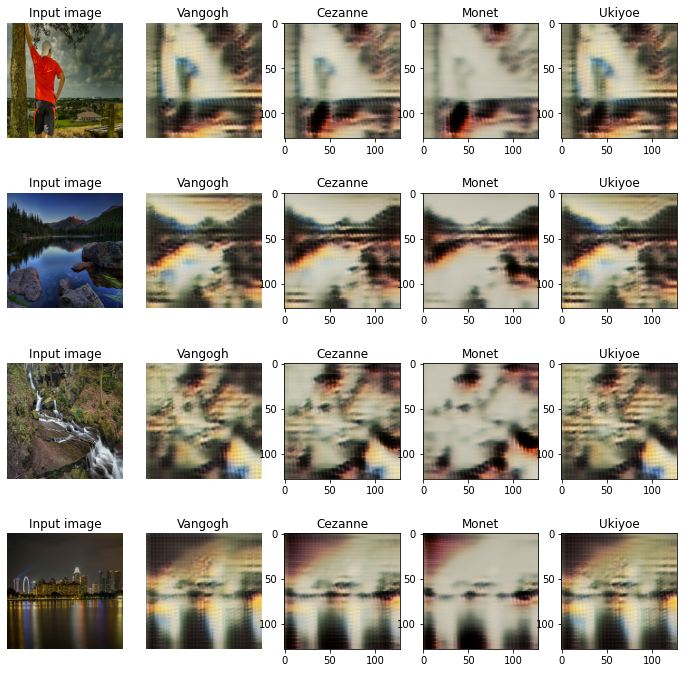

400/400 [==============================] - 281s 702ms/step - Generator_G_loss: 6.6735 - Generator_F_loss: 5.5872 - Content_Discriminator_loss: 0.1545 - Style_Discriminator_loss: 0.2115
Epoch 2/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 5.9004 - Generator_F_loss: 4.9536 - Content_Discriminator_loss: 0.1385 - Style_Discriminator_loss: 0.2438

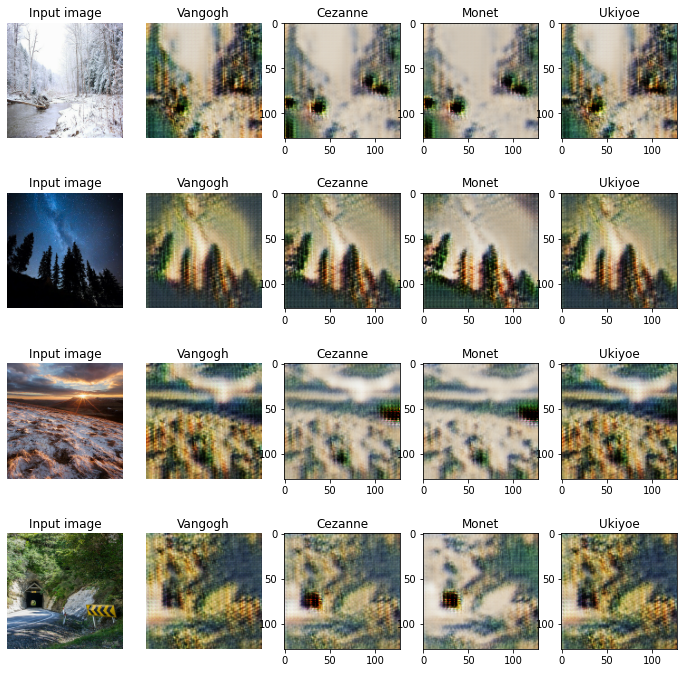

400/400 [==============================] - 282s 705ms/step - Generator_G_loss: 5.8993 - Generator_F_loss: 4.9543 - Content_Discriminator_loss: 0.1384 - Style_Discriminator_loss: 0.2435
Epoch 3/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 5.3347 - Generator_F_loss: 4.5890 - Content_Discriminator_loss: 0.1491 - Style_Discriminator_loss: 0.2847

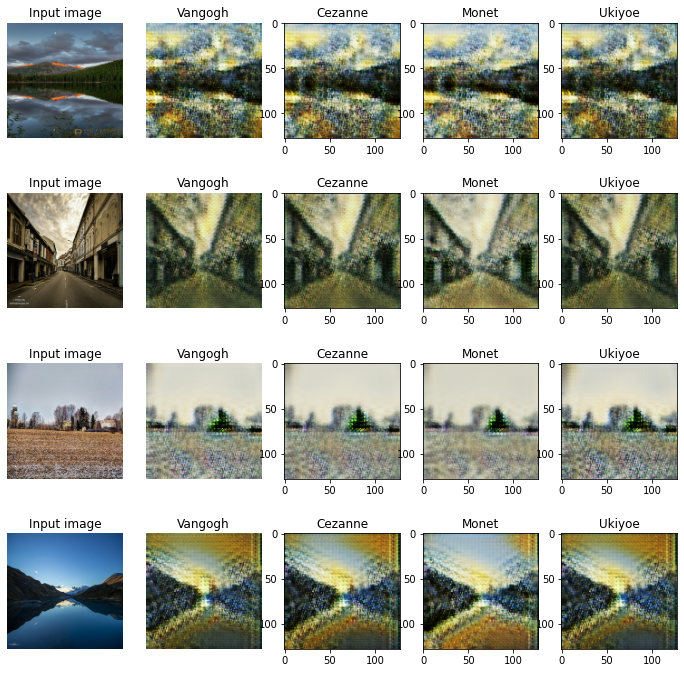

400/400 [==============================] - 285s 712ms/step - Generator_G_loss: 5.3329 - Generator_F_loss: 4.5874 - Content_Discriminator_loss: 0.1490 - Style_Discriminator_loss: 0.2847
Epoch 4/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 5.0932 - Generator_F_loss: 4.5164 - Content_Discriminator_loss: 0.1186 - Style_Discriminator_loss: 0.3160

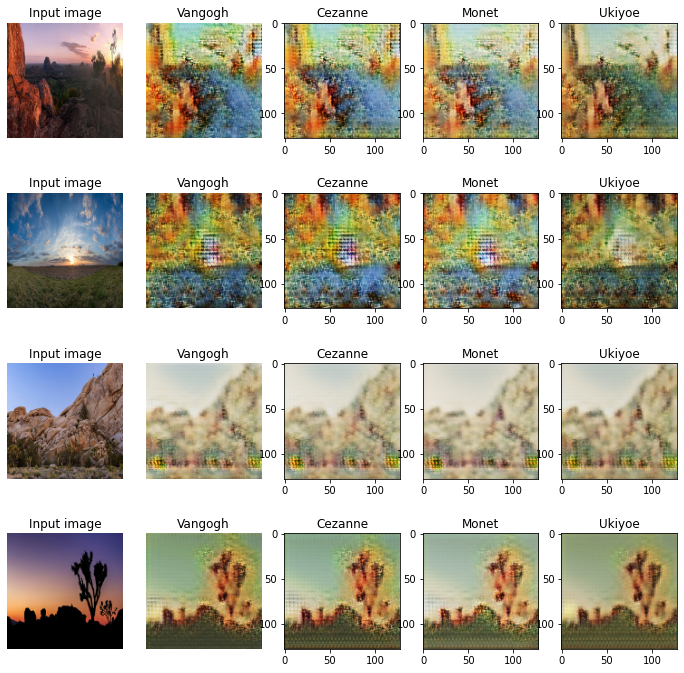

400/400 [==============================] - 283s 707ms/step - Generator_G_loss: 5.0939 - Generator_F_loss: 4.5168 - Content_Discriminator_loss: 0.1188 - Style_Discriminator_loss: 0.3157
Epoch 5/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 4.9050 - Generator_F_loss: 4.5318 - Content_Discriminator_loss: 0.1614 - Style_Discriminator_loss: 0.3205

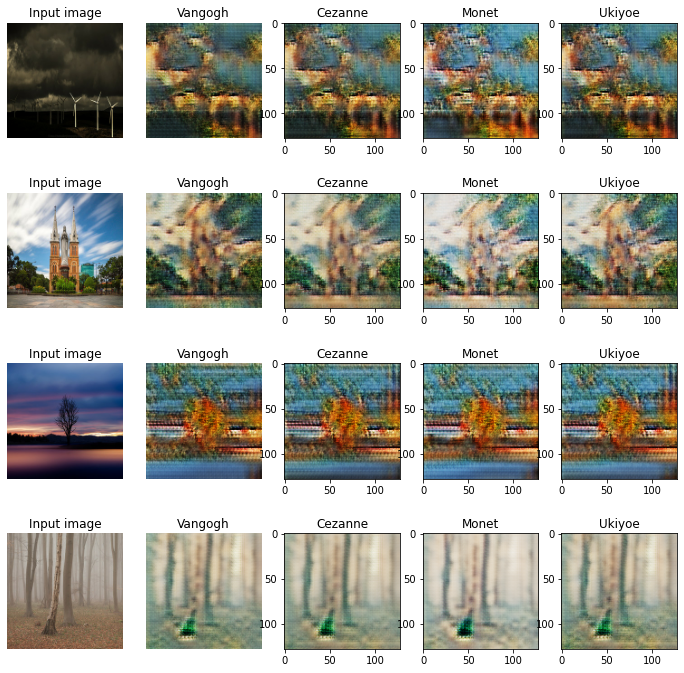

400/400 [==============================] - 283s 707ms/step - Generator_G_loss: 4.9025 - Generator_F_loss: 4.5355 - Content_Discriminator_loss: 0.1612 - Style_Discriminator_loss: 0.3207


In [ ]:
#referenced https://keras.io/examples/generative/cyclegan/

# Get the generators
gen_G = Generator()
gen_F = Generator()

# Get the discriminators
discrim_Content = Discriminator()
discrim_Style = Discriminator()

# Create cycle gan model
cycle_gan_model = CycleGan(
    gen_G=gen_G, gen_F=gen_F, discrim_Content=discrim_Content, discrim_Style=discrim_Style
)

# Compile the model
cycle_gan_model.compile(
    gen_G_opt=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_opt=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    discrim_Content_opt=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    discrim_Style_opt=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
)

# Callbacks to monitor the training after every epoch
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

# Here we will train the model. Each epoch takes around 12 minutes on a google colab GPU
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_photo, train_painter1[0][0], train_painter1[1][0], train_painter1[2][0], train_painter1[3][0])),
    epochs=5,
    callbacks=[plotter, model_checkpoint_callback],
)

Epoch 1/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 4.8489 - Generator_F_loss: 4.6528 - Content_Discriminator_loss: 0.1870 - Style_Discriminator_loss: 0.3223

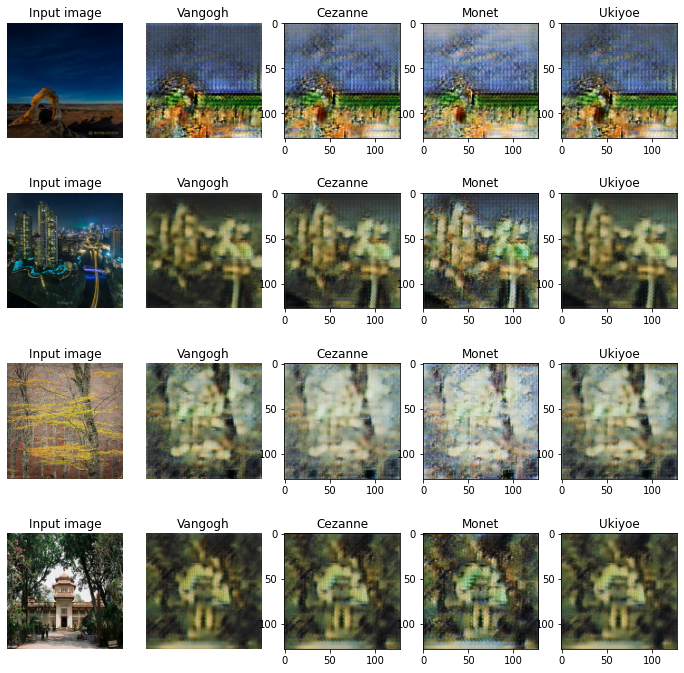

400/400 [==============================] - 280s 699ms/step - Generator_G_loss: 4.8470 - Generator_F_loss: 4.6612 - Content_Discriminator_loss: 0.1868 - Style_Discriminator_loss: 0.3226
Epoch 2/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 4.7790 - Generator_F_loss: 4.5942 - Content_Discriminator_loss: 0.1758 - Style_Discriminator_loss: 0.3241

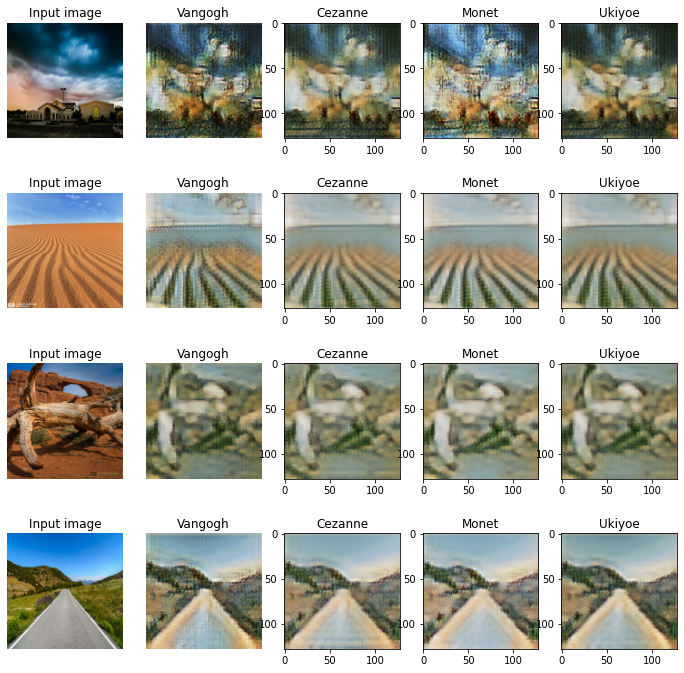

400/400 [==============================] - 281s 703ms/step - Generator_G_loss: 4.7773 - Generator_F_loss: 4.5925 - Content_Discriminator_loss: 0.1757 - Style_Discriminator_loss: 0.3241
Epoch 3/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 4.7079 - Generator_F_loss: 4.6119 - Content_Discriminator_loss: 0.1866 - Style_Discriminator_loss: 0.3030

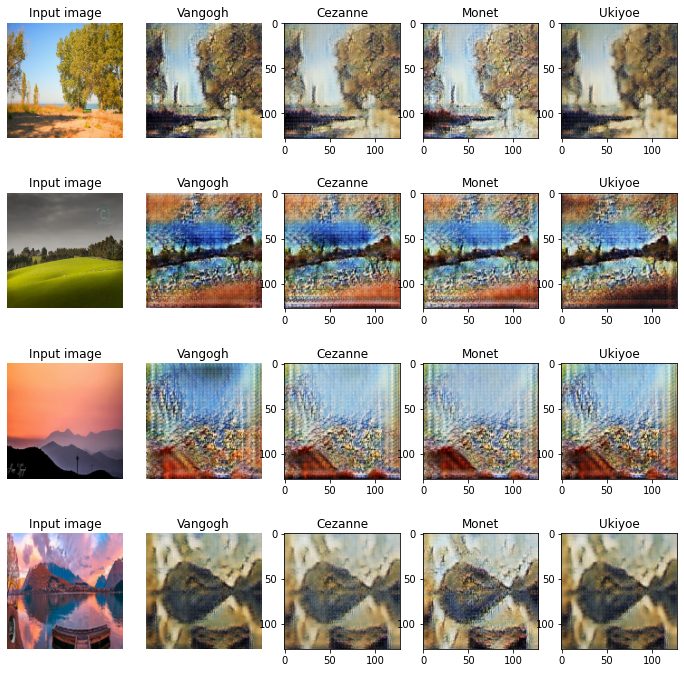

400/400 [==============================] - 282s 706ms/step - Generator_G_loss: 4.7067 - Generator_F_loss: 4.6101 - Content_Discriminator_loss: 0.1864 - Style_Discriminator_loss: 0.3028
Epoch 4/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 4.6876 - Generator_F_loss: 4.7791 - Content_Discriminator_loss: 0.1790 - Style_Discriminator_loss: 0.3208

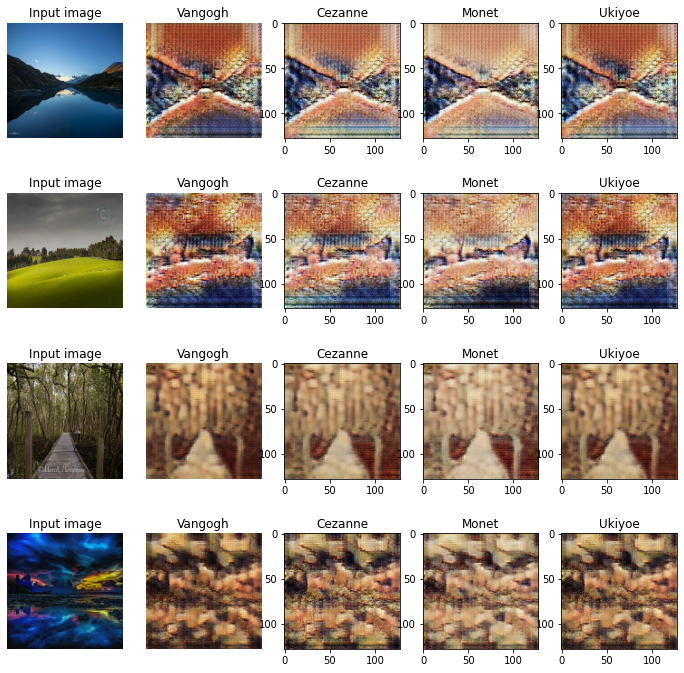

400/400 [==============================] - 282s 705ms/step - Generator_G_loss: 4.6924 - Generator_F_loss: 4.7775 - Content_Discriminator_loss: 0.1795 - Style_Discriminator_loss: 0.3209
Epoch 5/5
400/400 [==============================] - ETA: 0s - Generator_G_loss: 4.6905 - Generator_F_loss: 4.7638 - Content_Discriminator_loss: 0.1889 - Style_Discriminator_loss: 0.3071

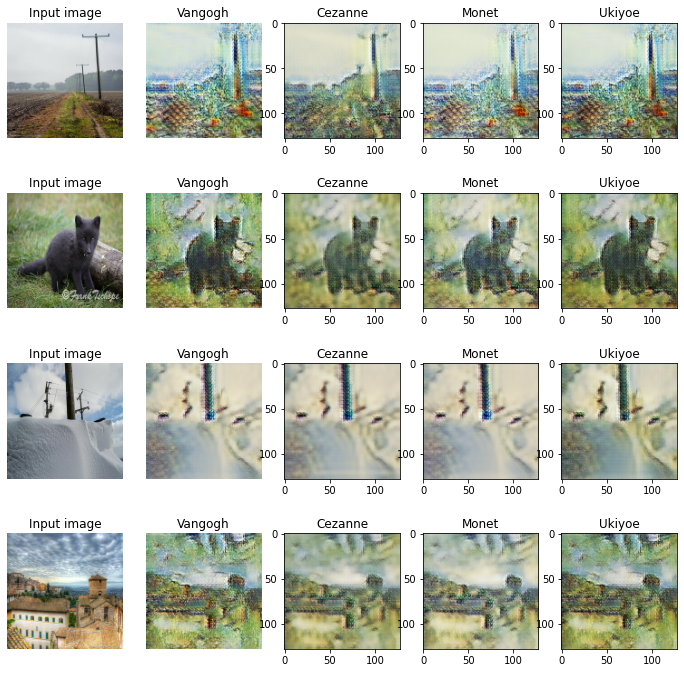

400/400 [==============================] - 282s 704ms/step - Generator_G_loss: 4.6899 - Generator_F_loss: 4.7680 - Content_Discriminator_loss: 0.1887 - Style_Discriminator_loss: 0.3070


In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_photo, train_painter1[0][0], train_painter1[1][0], train_painter1[2][0], train_painter1[3][0])),
    epochs=5,
    callbacks=[plotter, model_checkpoint_callback],
)

In [ ]:
cycle_gan_model.save_weights('/content/final_weights/cycle_gan')

We attempt to save the model below, but were unsuccessful in doing so because it is a subclassed model and we did not define any initial weights, we are unable to save. We saved the weights of the model instead, and are able to load the weights onto a model, having a similar effect of uploading a .hd5 file.

In [ ]:
import h5py
cycle_gan_model.save('final_model.h5')

NotImplementedError: ignored

### Evaluation using FID Score

In [ ]:
#FID score
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm

from tensorflow.keras.applications.inception_v3 import InceptionV3
fid_model = InceptionV3()

from tensorflow.keras.applications.inception_v3 import preprocess_input

from skimage.transform import resize

In [ ]:
def fid_calc(fid_model, gen_images, style_images):
  #calculation of activations
	gen_act = fid_model.predict(gen_images)
	style_act = fid_model.predict(style_images)
	# calculate mean and covariance statistics
	gen_mean, gen_sigma = gen_act.mean(axis=0), cov(gen_act, rowvar=False)
	style_mean, style_sigma = style_act.mean(axis=0), cov(style_act, rowvar=False)
	# calculate sum squared difference between means
	sum_sq_diff = np.sum((gen_mean - style_mean)**2.0)
	# calculate sqrt of product between cov
	cov_mean = sqrtm(gen_sigma.dot(style_sigma))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(cov_mean):
		cov_mean = cov_mean.real
	# calculate score
	fid = sum_sq_diff + trace(gen_sigma + style_sigma - 2.0 * cov_mean)
	return fid
 
 # scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [ ]:
import cv2
import glob

num_images_per_painter = 250

imdir1 = '/content/style1/'
ext = ['png', 'jpg']    # Add image formats here

files1 = []
[files1.extend(glob.glob(imdir1 + '*.' + e)) for e in ext]
gen_images1 = [cv2.imread(file) for file in files1]
gen_images1 = np.array(gen_images1)

imdir2 = '/content/style2/'

files2 = []
[files2.extend(glob.glob(imdir2 + '*.' + e)) for e in ext]
gen_images2 = [cv2.imread(file) for file in files2]
gen_images2 = np.array(gen_images2)

imdir3 = '/content/style3/'

files3 = []
[files3.extend(glob.glob(imdir3 + '*.' + e)) for e in ext]
gen_images3 = [cv2.imread(file) for file in files3]
gen_images3 = np.array(gen_images3)

imdir4 = '/content/style4/'

files4 = []
[files4.extend(glob.glob(imdir4 + '*.' + e)) for e in ext]
gen_images4 = [cv2.imread(file) for file in files4]
gen_images4 = np.array(gen_images4)




vangogh_list = []
for i, samples in enumerate(zip(test_painter1[0][0].take(num_images_per_painter))):
  vangogh = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
  vangogh = keras.preprocessing.image.array_to_img(vangogh)
  vangogh_list.append(vangogh)

vangogh_pixel_list = []
for i in range(len(vangogh_list)):
  vangogh_pixel_list.append(np.array(vangogh_list[i]))

vangogh_style_images = np.array(vangogh_pixel_list)


cezanne_list = []
for i, samples in enumerate(zip(test_painter1[1][0].take(num_images_per_painter))):
  cezanne = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
  cezanne = keras.preprocessing.image.array_to_img(cezanne)
  cezanne_list.append(cezanne)

cezanne_pixel_list = []
for i in range(len(cezanne_list)):
  cezanne_pixel_list.append(np.array(cezanne_list[i]))

cezanne_style_images = np.array(cezanne_pixel_list)


monet_list = []
for i, samples in enumerate(zip(test_painter1[2][0].take(num_images_per_painter))):
  monet = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
  monet = keras.preprocessing.image.array_to_img(monet)
  monet_list.append(monet)

monet_pixel_list = []
for i in range(len(monet_list)):
  monet_pixel_list.append(np.array(monet_list[i]))

monet_style_images = np.array(monet_pixel_list)



ukiyoe_list = []
for i, samples in enumerate(zip(test_painter1[3][0].take(num_images_per_painter))):
  ukiyoe = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
  ukiyoe = keras.preprocessing.image.array_to_img(ukiyoe)
  ukiyoe_list.append(ukiyoe)

ukiyoe_pixel_list = []
for i in range(len(ukiyoe_list)):
  ukiyoe_pixel_list.append(np.array(ukiyoe_list[i]))

ukiyoe_style_images = np.array(ukiyoe_pixel_list)

In [ ]:
fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(128,128,3))
# convert integer to floating point values
gen_images1 = gen_images1.astype('float32')
vangogh_style_images = vangogh_style_images.astype('float32')

gen_images2 = gen_images2.astype('float32')
cezanne_style_images = cezanne_style_images.astype('float32')

gen_images3 = gen_images3.astype('float32')
monet_style_images = monet_style_images.astype('float32')

gen_images4 = gen_images4.astype('float32')
ukiyoe_style_images = ukiyoe_style_images.astype('float32')



gen_images1 = scale_images(gen_images1, (128,128,3))
vangogh_style_images = scale_images(vangogh_style_images, (128,128,3))

gen_images2 = scale_images(gen_images2, (128,128,3))
cezanne_style_images = scale_images(cezanne_style_images, (128,128,3))

gen_images3 = scale_images(gen_images3, (128,128,3))
monet_style_images = scale_images(monet_style_images, (128,128,3))

gen_images4 = scale_images(gen_images4, (128,128,3))
ukiyoe_style_images = scale_images(ukiyoe_style_images, (128,128,3))




gen_images1 = preprocess_input(gen_images1)
vangogh_style_images = preprocess_input(vangogh_style_images)

gen_images2 = preprocess_input(gen_images2)
cezanne_style_images = preprocess_input(cezanne_style_images)

gen_images3 = preprocess_input(gen_images3)
monet_style_images = preprocess_input(monet_style_images)

gen_images4 = preprocess_input(gen_images4)
ukiyoe_style_images = preprocess_input(ukiyoe_style_images)


# calculate fid
fid_vangogh = fid_calc(fid_model, gen_images1, vangogh_style_images)
fid_cezanne = fid_calc(fid_model, gen_images2, cezanne_style_images)
fid_monet = fid_calc(fid_model, gen_images3, monet_style_images)
fid_ukiyoe = fid_calc(fid_model, gen_images4, ukiyoe_style_images)
print('\tVangogh \tCezanne \tMonet \t\tUkiyoe')
print('---------------------------------------------------------------------')
print('FID: %.3f \t\t%.3f \t%.3f \t%.3f' % (fid_vangogh, fid_cezanne, fid_monet, fid_ukiyoe))

	Vangogh 	Cezanne 	Monet 		Ukiyoe
---------------------------------------------------------------------
FID: 2370.253 		3258.643 	2272.889 	2664.582
